In [2]:
import gym
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

Generation: 0 	 Score: -97.11727875777107


d:\miniconda\lib\site-packages\pyglet\image\codecs\wic.py:406: UserWarning: [WinError -2147417850] Impossible de modifier le mode thread une fois qu’il a été fixé
  warnings.warn(str(err))


Generation: 1 	 Score: -86.21337480016341
Generation: 2 	 Score: -72.75906894483973
Generation: 3 	 Score: -47.13953449130682
Generation: 4 	 Score: 70.65438029241987
Generation: 5 	 Score: 88.88323654544446
Generation: 6 	 Score: 85.31926638769465
Generation: 7 	 Score: 87.76611613586367
Generation: 8 	 Score: 107.70772850296191
Generation: 9 	 Score: 112.32959657797262
Generation: 10 	 Score: 117.59788260786297
Generation: 11 	 Score: 129.8164853474466
Generation: 12 	 Score: 122.42765927577386
Generation: 13 	 Score: 121.8906944495756
Generation: 14 	 Score: 151.59724094577314
Generation: 15 	 Score: 137.96796825620345
Generation: 16 	 Score: 138.1550340543968
Generation: 17 	 Score: 140.93360791982212
Generation: 18 	 Score: 127.86630586646288
Generation: 19 	 Score: 125.22949132819821
Generation: 20 	 Score: 132.51060128292895
Generation: 21 	 Score: 139.82400366347545
Generation: 22 	 Score: 147.35666341385084
Generation: 23 	 Score: 153.7428158059686
Generation: 24 	 Score: 174.

KeyboardInterrupt: 

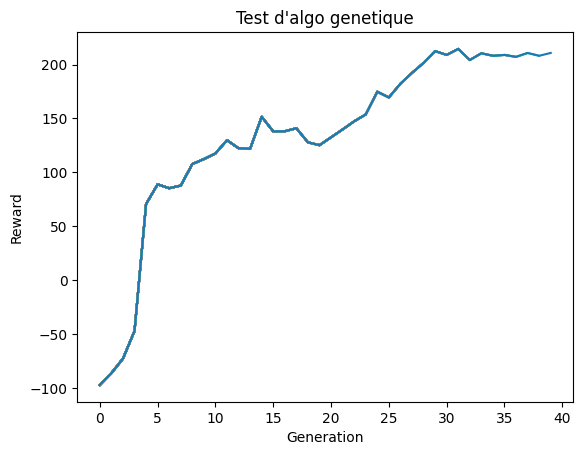

In [3]:
def glorot_uniform(n_inputs,n_outputs,multiplier=1.0):
    glorot = multiplier*np.sqrt(2.0/(n_inputs+n_outputs))
    return np.random.uniform(-glorot,glorot,size=(n_inputs,n_outputs))
def softmax(x,temperature=5.0):
    exp = np.exp(np.array(x)/temperature)
    return exp/exp.sum()

class Agent :
    def __init__(self,n_inputs, n_hidden, n_outputs, mutate_rate=0.05, init_multiplier=1.0):
        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_outputs = n_outputs
        self.mutate_rate = mutate_rate
        self.init_multiplier = init_multiplier
        self.network = {'Layer 1': glorot_uniform(n_inputs,n_hidden,init_multiplier),
                        'Bias 1': np.zeros((1,n_hidden)),
                        'Layer 2': glorot_uniform(n_hidden,n_outputs,init_multiplier),
                        'Bias 2': np.zeros((1,n_outputs))
                        }
    def act(self,state):
        if(state.shape[0]!=1):
            state = state.reshape(1,-1)
        net= self.network
        layer_one = np.tanh(np.matmul(state,net['Layer 1']) + net['Bias 1'])
        layer_two = np.tanh(np.matmul(layer_one, net['Layer 2']) + net['Bias 2'])
        return layer_two[0]
    def __add__(self,another):
        child = deepcopy(self)
        for key in child.network.keys():
            n_inputs,n_outputs = child.network[key].shape
            mask = np.random.choice([0,1],size=child.network[key].shape,p=[.5,.5])
            random = glorot_uniform(mask.shape[0],mask.shape[1]) 
            child.network[key] = np.where(mask==1,self.network[key],another.network[key])
            mask = np.random.choice([0,1],size=child.network[key].shape,p=[1-self.mutate_rate,self.mutate_rate]) 
            child.network[key] = np.where(mask==1,child.network[key]+random,child.network[key]) 
        return child
def run_trial(env,agent,render=False):
    totals=[]
    for _ in range(3):
        state= env.reset()
        if render : env.render()
        total_reward = 0
        done = False
        while not done:
            state, reward, done, _ = env.step(agent.act(state))
            if reward >= 100:
                env.render()
            total_reward += reward
        totals.append(total_reward)
    return np.mean(totals)
def next_generation(env,population,scores,temperature):
    
    scores, population =  zip(*sorted(zip(scores,population),reverse=True)) 
    children = list(population[:len(population)//4])
    parents = list(np.random.choice(population,size=2*(len(population)-len(children)),p=softmax(scores,temperature)))
    children = children + [parents[i]+parents[i+1] for i in range(0,len(parents)-1,2)]
    scores = [run_trial(env,agent) for agent in children]
    return children, scores


def main():
    graph = plt.plot([],[]) 
    env = gym.make('BipedalWalker-v3')
    env.seed(0)
    np.random.seed(0)
    genlist=[]
    rewardlist=[]
    n_inputs = env.observation_space.shape[0]
    n_actions = env.action_space.shape[0] 
    n_hidden = 512 
    multiplier = 5
    
    pop_size = 50
    mutate_rate = .1
    softmax_temp = 5.0
    count=0
    n_generations = 80
    population = [Agent(n_inputs,n_hidden,n_actions,mutate_rate,multiplier) for _ in range(pop_size)]
    scores = [run_trial(env,agent) for agent in population]
    best = [deepcopy(population[np.argmax(scores)])]
    for _ in range (n_generations):
        population, scores = next_generation(env,population,scores,softmax_temp)
        best.append(deepcopy(population[np.argmax(scores)]))
        print("Generation: {} \t Score: {}".format(count,np.max(scores)))
        genlist+=[count]
        rewardlist += [np.max(scores)]
        xpoints = np.array(genlist)
        ypoints = np.array(rewardlist)
        plt.plot(xpoints, ypoints)
        plt.title("Test d'algo genetique")
        plt.xlabel("Generation")
        plt.ylabel("Reward")
        count+=1
        if count>=70:
            plt.show()
        if n_generations>0 & n_generations%5==0:
            env = gym.wrappers.Monitor(env, './monitor_output', force=True,video_callable=lambda episode_id: episode_id%3==0)
            for agent in best:
                run_trial(env,agent,render=True)
            env.close()
    env = gym.wrappers.Monitor(env, './monitor_output', force=True,video_callable=lambda episode_id: episode_id%3==0)
    for agent in best:
        run_trial(env,agent,render=True)
    env.close()

if __name__ == '__main__':
    main()